In [1]:
import torch
# Detectar el dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [2]:
#1. Importamos el dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/sports-classification")

In [3]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 2. Definimos las transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convertimos imágenes a Tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 3. Cargar dataset
train_data = datasets.ImageFolder(root=f"{path}/train", transform=transform)
test_data = datasets.ImageFolder(root=f"{path}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=75, shuffle=True)
test_loader = DataLoader(test_data, batch_size=75, shuffle=False)

# 4. Mostrar clases
print(f"Clases encontradas: {train_data.classes}")
print(f"Numero clases encontradas: {len(train_data.classes)}")

Clases encontradas: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock

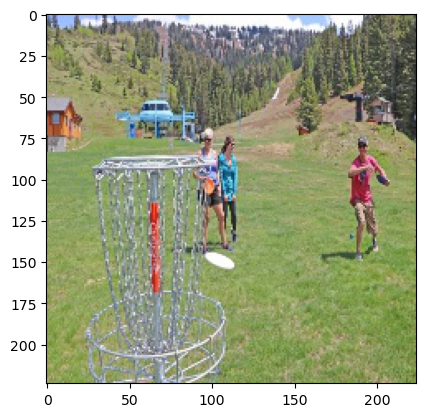

In [4]:
# 5. Vamos a visualizar una imagen del dataset
import matplotlib.pyplot as plt
import numpy as np

# Obtenemos una imagen del dataset
i = np.random.randint(len(train_data))
image, label = train_data[i]
image = image.unsqueeze(0).to(device)

plt.imshow(image.cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.show()

In [5]:
import torch.nn as nn
import torch.nn.functional as F

#5. Definimos el modelo
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)  # Entrada: 3 canales, Salida: 32 canales, kernel de 5x5
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling con un kernel de 2x2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)  # Entrada: 32 canales, Salida: 64 canales
        self.fc1 = nn.Linear(64 * 56 * 56, 256)  # Imágenes reducidas a 224x224 después del pooling
        self.fc2 = nn.Linear(256, 100)  # 100 clases de salida para MNIST

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Aplanar
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ConvNet().to(device)
print(model)
print("Número de parámetros:", sum(p.numel() for p in model.parameters()))

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=200704, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
)
Número de parámetros: 51459876


In [6]:
# 6. Predicción antes del entrenamiento
model.eval()
with torch.no_grad():
    output = model(image)  # Agregar dimensión batch
    _, pred = torch.max(output, 1)  # Índice de la mayor probabilidad

# Mostrar resultados
print(f"Etiqueta real: {train_data.classes[label]}")
print(f"Predicción del modelo: {train_data.classes[pred]}")

Etiqueta real: disc golf
Predicción del modelo: axe throwing


In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
#6. Entrenamiento
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Limpiamos los gradientes
        outputs = model(images)  # Pasamos las imágenes por la red
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizamos los pesos

        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

Epoch 1, Loss: 4.684784573978848
Epoch 2, Loss: 4.599706551763746
Epoch 3, Loss: 4.5960863404803804
Epoch 4, Loss: 4.594496064715916
Epoch 5, Loss: 4.594025752279493
Epoch 6, Loss: 4.570491075515747
Epoch 7, Loss: 4.274174213409424
Epoch 8, Loss: 3.9790330052375795
Epoch 9, Loss: 3.3717060804367067
Epoch 10, Loss: 2.1896049910121493


In [9]:
#7. EValuación
correct = 0
total = 0
with torch.no_grad():  # No necesitamos calcular gradientes para la evaluación
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #predicción despues del entrenamiento
        output = model(image)  # Agregar dimensión batch
        _, pred = torch.max(output, 1)  # Índice de la mayor probabilidad

print(f'Accuracy of the model on the test images: {100 * correct / total}%')
# Mostrar resultados
print(f"Etiqueta real: {train_data.classes[label]}")
print(f"Predicción del modelo: {train_data.classes[pred]}")

Accuracy of the model on the test images: 15.8%
Etiqueta real: disc golf
Predicción del modelo: disc golf
